In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob

from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add


from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.models import Model
from keras.models import load_model 
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from tqdm import tqdm
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Flickr_Data.zip" -d "/content/"
!unzip "/content/drive/MyDrive/glove.6B.200d.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Flickr_Data/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/Flickr_Data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: /content/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: /content/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: /content/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: /content/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: /content/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: /content/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/Flickr_Data/Images/2848977044_

In [ ]:
#We will define all the paths to the files that we require and save the images id and their captions.
token_path = "/content/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
train_images_path = "/content/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt"
test_images_path = "/content/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt"
images_path = '/content/Flickr_Data/Images/'
glove_path = '/content/glove.6B.200d.txt'

In [ ]:
doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

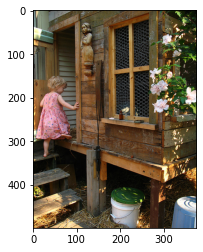

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]

print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)
print('Train Dataset size: %d' % len(train))

Train Dataset size: 6000


In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)
        
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [ ]:
train_img

['/content/Flickr_Data/Images/2243904502_2d265fed80.jpg',
 '/content/Flickr_Data/Images/3459419203_cd7c68ce4d.jpg',
 '/content/Flickr_Data/Images/2188192752_09d9fc5431.jpg',
 '/content/Flickr_Data/Images/3176277818_235486a3cd.jpg',
 '/content/Flickr_Data/Images/254527963_3f5824b0e8.jpg',
 '/content/Flickr_Data/Images/2638981862_6b23833f37.jpg',
 '/content/Flickr_Data/Images/2206403470_8c25aa3cf8.jpg',
 '/content/Flickr_Data/Images/241346402_5c070a0c6d.jpg',
 '/content/Flickr_Data/Images/1312020846_5abb4a9be2.jpg',
 '/content/Flickr_Data/Images/3639617775_149001232a.jpg',
 '/content/Flickr_Data/Images/3054997030_797096dd12.jpg',
 '/content/Flickr_Data/Images/3003612178_8230d65833.jpg',
 '/content/Flickr_Data/Images/278002947_3fd22a2cb6.jpg',
 '/content/Flickr_Data/Images/2885111681_dc328ecfff.jpg',
 '/content/Flickr_Data/Images/3331102049_bc65cf6198.jpg',
 '/content/Flickr_Data/Images/2337919839_df83827fa0.jpg',
 '/content/Flickr_Data/Images/3648097366_706c8a57a1.jpg',
 '/content/Flickr

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

print('Descriptions: train = %d' % len(train_descriptions))

Descriptions: train = 6000


In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1660

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc

max_length = max(len(d.split()) for d in lines)
print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
embeddings_index = {} 
f = open("/content/glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# from tqdm import tqdm
# encoding_train = {}
# for img in tqdm(train_img):
#     encoding_train[img[len(images_path):]] = encode(img)

# train_features = encoding_train

In [ ]:
# encoding_test = {}
# for img in tqdm(test_img):
#     encoding_test[img[len(images_path):]] = encode(img)

In [ ]:
# import pickle

In [ ]:
# with open("encoding_train_auto_caps_kaggle.p", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle) 

In [ ]:
# with open("encoding_test_auto_caps_kaggle.p", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [ ]:
encoding_train = pickle.load(open('/content/encoding_train_auto_caps_kaggle.p', 'rb'))
train_features = encoding_train

In [ ]:
encoding_test = pickle.load(open('/content/encoding_test_auto_caps_kaggle.p', 'rb'))

In [ ]:
# inputs1 = Input(shape=(2048,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)

# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(256)(se2)

# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.summary()

model = load_model("auto_caps_kaggle.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

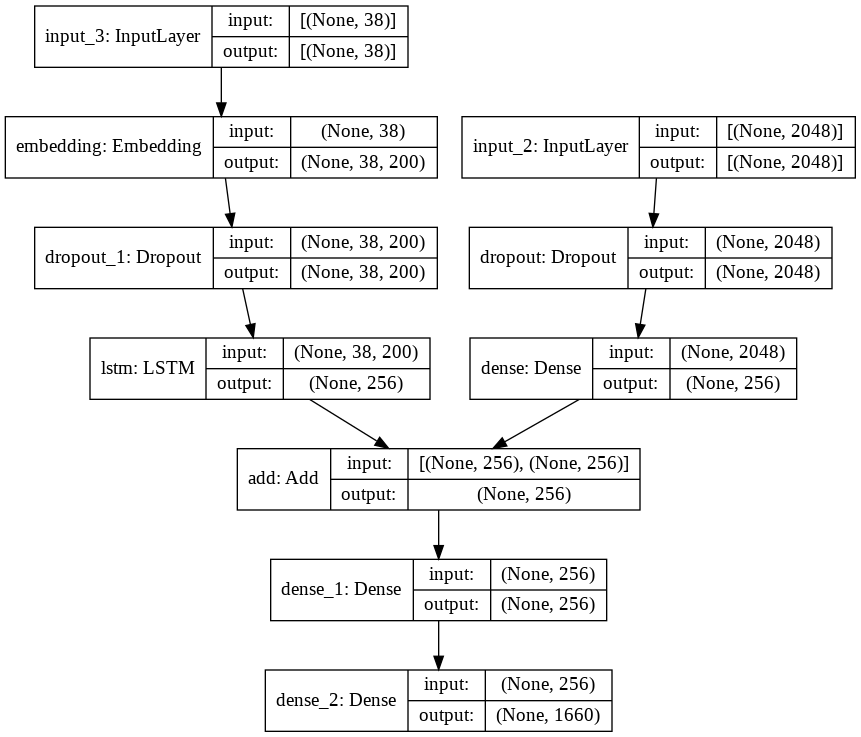

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='auto_caps_kaggle_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model.layers[2].set_weights([embedding_matrix])
# model.layers[2].trainable = False

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/20
2000/2000 [==============================] - 290s 144ms/step - loss: 2.2239
Epoch 2/20
2000/2000 [==============================] - 281s 141ms/step - loss: 2.2161
Epoch 3/20
2000/2000 [==============================] - 283s 141ms/step - loss: 2.2094
Epoch 4/20
2000/2000 [==============================] - 285s 143ms/step - loss: 2.2009
Epoch 5/20
2000/2000 [==============================] - 287s 143ms/step - loss: 2.1948
Epoch 6/20
2000/2000 [==============================] - 283s 142ms/step - loss: 2.1863
Epoch 7/20
2000/2000 [==============================] - 279s 140ms/step - loss: 2.1793
Epoch 8/20
2000/2000 [==============================] - 283s 142ms/step - loss: 2.1740
Epoch 9/20
2000/2000 [==============================] - 285s 143ms/step - loss: 2.1684
Epoch 10/20
2000/2000 [==============================] - 283s 141ms/step - loss: 2.1627
Epoch 11/20
2000/2000 [==============================] - 283s 141ms/step - loss: 2.1566
Epoch 12/20
2000/2000 [==================

In [ ]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=10, steps_per_epoch=steps, verbose=1)
model.save("auto_caps_kaggle_.h5") 


Epoch 1/10
2000/2000 [==============================] - 278s 139ms/step - loss: 2.1191
Epoch 2/10
2000/2000 [==============================] - 275s 137ms/step - loss: 2.1164
Epoch 3/10
2000/2000 [==============================] - 274s 137ms/step - loss: 2.1124
Epoch 4/10
2000/2000 [==============================] - 272s 136ms/step - loss: 2.1082
Epoch 5/10
2000/2000 [==============================] - 273s 137ms/step - loss: 2.1079
Epoch 6/10
2000/2000 [==============================] - 273s 137ms/step - loss: 2.1045
Epoch 7/10
2000/2000 [==============================] - 270s 135ms/step - loss: 2.1003
Epoch 8/10
2000/2000 [==============================] - 272s 136ms/step - loss: 2.0993
Epoch 9/10
2000/2000 [==============================] - 271s 136ms/step - loss: 2.0944
Epoch 10/10
2000/2000 [==============================] - 269s 134ms/step - loss: 2.0951


In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
model.save("auto_caps_kaggle_2.234.h5") 
# # loaded_model = load_model("auto_caps_kaggle.h5")

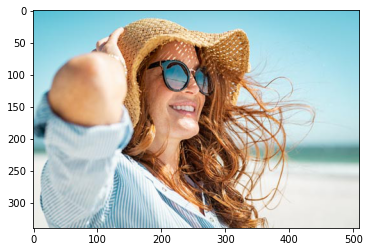

Greedy: a woman in a black tank top and jeans is sitting in a bus
Beam Search, K = 3: a woman in a black tank top and jeans is riding a bus in front of a crowd
Beam Search, K = 5: a woman in a black tank top is sitting in front of a green umbrella
Beam Search, K = 7: a little girl in a pink tank top is smiling whilst standing in front of a pool
Beam Search, K = 10: a woman in a black tank top holding a plastic bag stands next to a bus


In [ ]:
from keras.preprocessing import image
pic = "/content/start-h.jpg"
encoding = encode(pic)
# pic = list(encoding_test.keys())[number]
img1 = encoding.reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(img1))
print("Beam Search, K = 3:",beam_search_predictions(img1, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(img1, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(img1, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(img1, beam_index = 10))

2170222061_e8bce4a32d.jpg


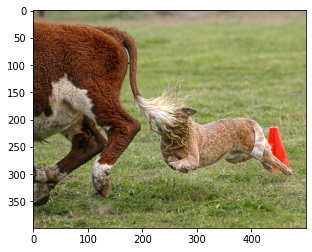

Greedy: a dog runs through a field
Beam Search, K = 3: a brown and white dog is running through a field
Beam Search, K = 5: a brown and white dog is running through a field
Beam Search, K = 7: a brown and white dog is running through a field
Beam Search, K = 10: a brown and white dog jumps over a black and white horse in a grassy field


In [ ]:
import random
number = random.randint(0, 1000)
pic = list(encoding_test.keys())[number]
print(pic)
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
from google.colab import files
files.download('/content/Flickr_Data/Images/' + pic)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
l.append(number)

In [ ]:

print(number)

100


'a group of people are pulling a sled in the snow'